In [209]:
# Librerie per manipolazione dati
import pandas as pd           # Analisi e manipolazione dati strutturati
import numpy as np           # Calcoli numerici e operazioni matematiche

# Librerie per visualizzazione
import matplotlib.pyplot as plt  # Creazione di grafici base
import seaborn as sns           # Visualizzazioni statistiche avanzate

# Librerie per Machine Learning
from sklearn.model_selection import train_test_split  # Divisione dataset train/test
from sklearn.compose import ColumnTransformer         # Preprocessing colonne diverse
from sklearn.preprocessing import OneHotEncoder, StandardScaler  # Encoding e scaling
from sklearn.pipeline import Pipeline                 # Creazione pipeline ML
from sklearn.linear_model import LinearRegression     # Modello di regressione lineare
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error  # Metriche


In [210]:
# caricamento del dataset
df = pd.read_csv('/home/giovanni/Programs/Python3/DataAnalyst-course/Esercizi/Giorno 13/CarPrice_Assignment.csv')
display(df.head())
print(f"Numero di righe: {df.shape[0]}, Numero di colonne: {df.shape[1]}")
print("Colonne del dataset:", df.columns.tolist())

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


Numero di righe: 205, Numero di colonne: 26
Colonne del dataset: ['car_ID', 'symboling', 'CarName', 'fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'enginetype', 'cylindernumber', 'enginesize', 'fuelsystem', 'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg', 'price']


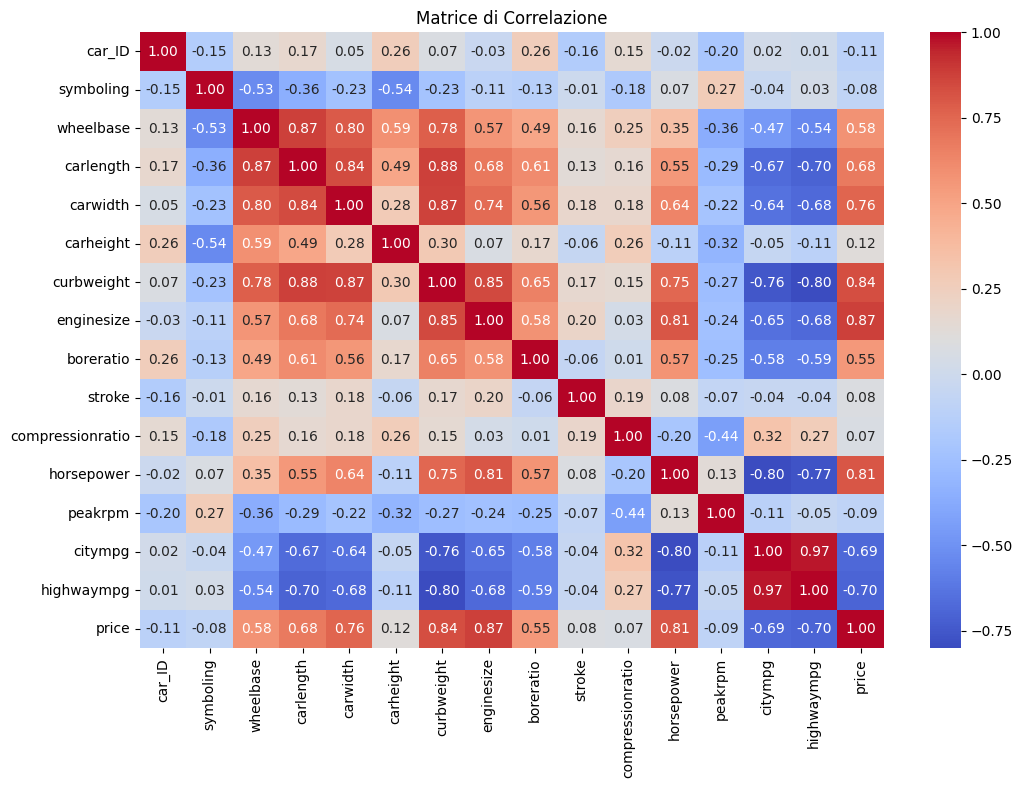

In [211]:
# esplorazione dei dati

# correlazione tra le variabili numeriche
plt.figure(figsize=(12, 8))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matrice di Correlazione')
plt.show()

In [212]:
# divisione delle colonne in numeriche e categoriche
numeric_features = numeric_df.columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

#categorical_features.append('symboling')
print("Colonne numeriche:", numeric_features)
print("Colonne categoriche:", categorical_features)

Colonne numeriche: ['car_ID', 'symboling', 'wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg', 'price']
Colonne categoriche: ['CarName', 'fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem']


In [213]:
# rimuovi car_ID, symboling e prezzo dalla lista delle colonne numeriche
numeric_features.remove('car_ID')
numeric_features.remove('symboling')
target = 'price'  # Colonna target
numeric_features.remove(target)

# rimuovi le colonne numeriche che non sono utili per la regressione (correlazione bassa con il target in valore assoluto)
numeric_features = [col for col in numeric_features if abs(numeric_df[col].corr(numeric_df[target])) > 0.15]
print("Colonne numeriche utili:", numeric_features)

Colonne numeriche utili: ['wheelbase', 'carlength', 'carwidth', 'curbweight', 'enginesize', 'boreratio', 'horsepower', 'citympg', 'highwaympg']


In [214]:
# studio delle colonne categoriche
# rimuovi CarName
categorical_features.remove('CarName')
print("Colonne categoriche:", categorical_features)

Colonne categoriche: ['fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem']


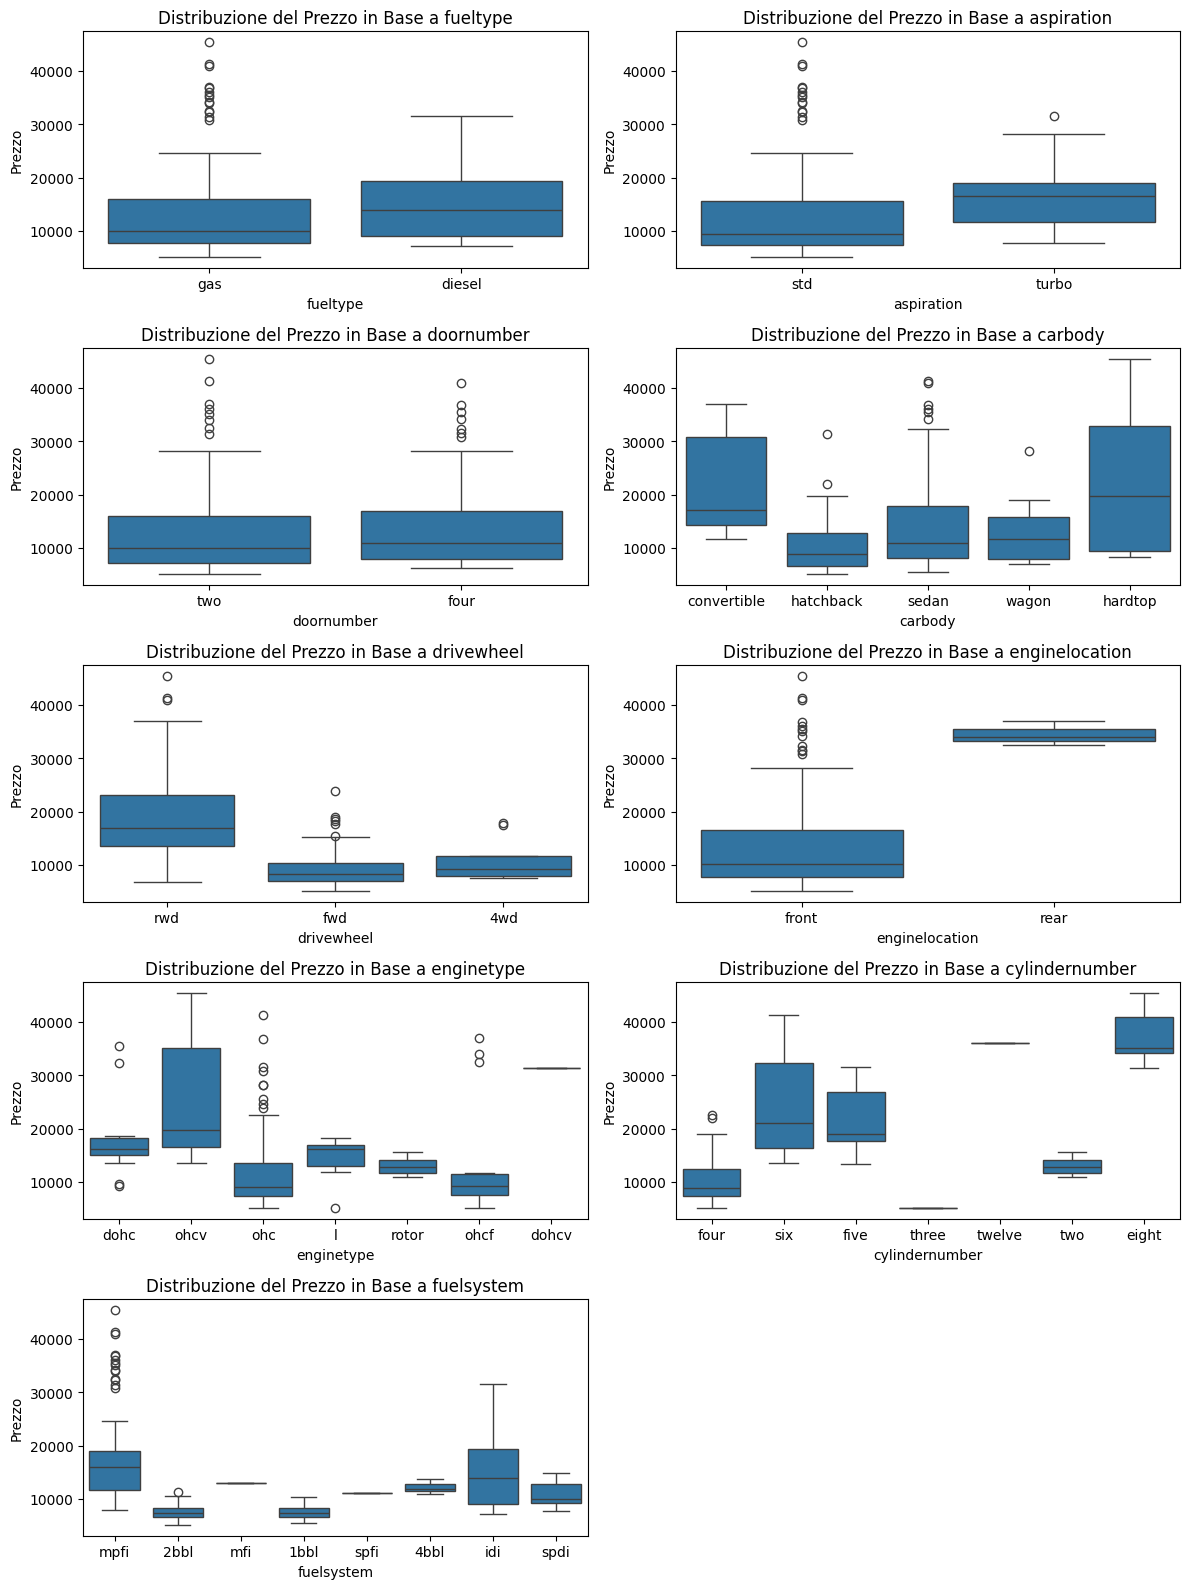

In [215]:
# crea una serie di boxplot per visualizzare la distribuzione del prezzo in base alle colonne categoriche
# e visualizzali in un unica figura
plt.figure(figsize=(12, 16))
for i, col in enumerate(categorical_features):
    plt.subplot(5, 2, i + 1)  # Modifica il layout in base al numero di colonne categoriche
    sns.boxplot(x=col, y='price', data=df)
    plt.title(f'Distribuzione del Prezzo in Base a {col}')
    plt.xlabel(col)
    plt.ylabel('Prezzo')
plt.tight_layout()
plt.show()


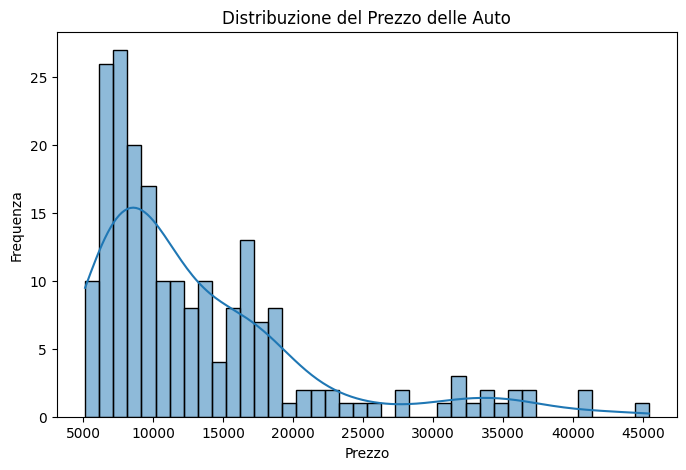

In [216]:
# istogramma distribuzione del prezzo 
plt.figure(figsize=(8, 5))
sns.histplot(df['price'], bins=40, kde=True)
plt.title('Distribuzione del Prezzo delle Auto')
plt.xlabel('Prezzo')
plt.ylabel('Frequenza')
plt.show()

In [217]:
# creazione del pipeline di preprocessing
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Standardizzazione delle feature numeriche
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))  # One-hot encoding delle feature categoriche
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [218]:
# creazione modello di regressione
model = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing dei dati
    ('regressor', LinearRegression())  # Modello di regressione lineare
])

In [219]:
# split del dataset in train e test
X = df[numeric_features + categorical_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Dimensioni del train set: {X_train.shape}, Dimensioni del test set: {X_test.shape}")

Dimensioni del train set: (164, 18), Dimensioni del test set: (41, 18)


In [220]:
# train del modello
model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [221]:
# calcolo delle metriche di valutazione
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"R^2: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

R^2: 0.8719
MAE: 2214.0368
MSE: 10110078.2010
RMSE: 3179.6349


/home/giovanni/Programs/Python3/DataAnalyst-course/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [222]:
# confronta i valori r2 tra train e test
train_r2 = r2_score(y_train, model.predict(X_train))
test_r2 = r2_score(y_test, y_pred)

print(f"\n📈 Confronto R^2:")
print(f"   • R^2 Train: {train_r2:.4f}")
print(f"   • R^2 Test: {test_r2:.4f}")


📈 Confronto R^2:
   • R^2 Train: 0.9355
   • R^2 Test: 0.8719


#### Dal confronto tra i valori R2_train e R2_test si nota che il modello va in overfitting, probabilmente a causa del numero limitato di dati rispetto al numero di variabili usate

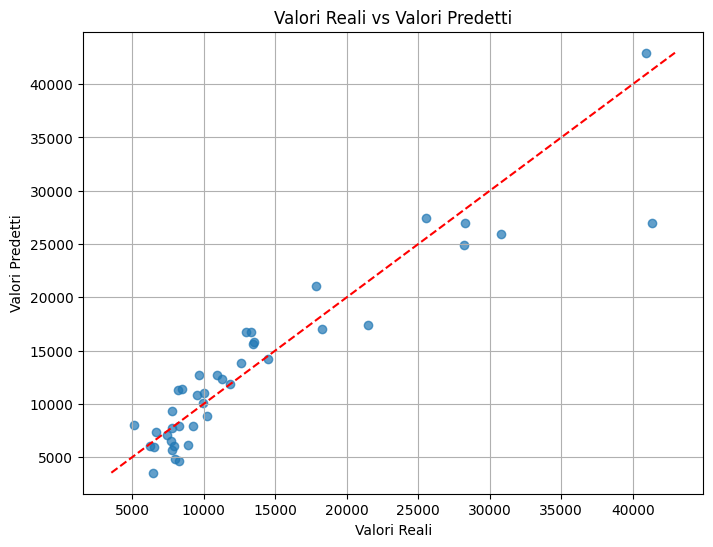

In [223]:
# plot dei valori reali vs predetti
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], color='red', linestyle='--')
plt.title('Valori Reali vs Valori Predetti')
plt.xlabel('Valori Reali')
plt.ylabel('Valori Predetti')
plt.grid()
plt.show()

In [224]:
print("🔬 ANALISI DELL'IMPORTANZA DELLE VARIABILI")
print("="*60)

# 1. ESTRAZIONE DEI COEFFICIENTI
print("1️⃣ Estrazione coefficienti dal modello addestrato...")

# Otteniamo i nomi delle features dopo il preprocessing
feature_names = model.named_steps["preprocessor"].get_feature_names_out()
print(f"   📋 Numero totale di features dopo preprocessing: {len(feature_names)}")

# Coefficienti del modello di regressione lineare
coefficients = model.named_steps["regressor"].coef_
print(f"   🔢 Numero di coefficienti estratti: {len(coefficients)}")

# Intercetta del modello
intercept = model.named_steps["regressor"].intercept_
print(f"   🏠 Intercetta del modello: {intercept:.4f}")

# 2. CREAZIONE DATAFRAME PER ANALISI
print("\n2️⃣ Organizzazione dei coefficienti...")

# Creiamo un DataFrame per analizzare meglio i coefficienti
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficiente': coefficients,
    'Importanza_Assoluta': np.abs(coefficients)  # Valore assoluto per ranking
}).sort_values('Importanza_Assoluta', ascending=False)

# Puliamo i nomi delle features per renderli più leggibili
coef_df['Feature_Pulita'] = coef_df['Feature'].str.replace('cat__', '').str.replace('num__', '')
display(coef_df[['Feature_Pulita', 'Coefficiente', 'Importanza_Assoluta']].head(10))

print(f"✅ DataFrame coefficienti creato e ordinato per importanza")

🔬 ANALISI DELL'IMPORTANZA DELLE VARIABILI
1️⃣ Estrazione coefficienti dal modello addestrato...
   📋 Numero totale di features dopo preprocessing: 37
   🔢 Numero di coefficienti estratti: 37
   🏠 Intercetta del modello: 25973.9648

2️⃣ Organizzazione dei coefficienti...


,Feature_Pulita,Coefficiente,Importanza_Assoluta
18,enginelocation_rear,12798.179282,12798.179282
26,cylindernumber_four,-12641.394365,12641.394365
27,cylindernumber_six,-11648.545416,11648.545416
25,cylindernumber_five,-11152.331695,11152.331695
19,enginetype_dohcv,-10936.012984,10936.012984
28,cylindernumber_twelve,-10230.840299,10230.840299
24,enginetype_rotor,-3964.006498,3964.006498
29,cylindernumber_two,-3964.006498,3964.006498
12,carbody_hardtop,-3898.096266,3898.096266
23,enginetype_ohcv,-3894.230406,3894.230406


✅ DataFrame coefficienti creato e ordinato per importanza


In [225]:
# 3. TOP VARIABILI PIÙ INFLUENTI
#print("\n3️⃣ Identificazione delle variabili più influenti...")

print(f"🏆 TOP VARIABILI PIÙ INFLUENTI:")
print("="*70)
print(f"{'Rank':<4} {'Variabile':<25} {'Coefficiente':<16} {'Impatto':<15}")
print("-"*70)

for i, (_, row) in enumerate(coef_df.iterrows(), 1):
    # Determiniamo il tipo di impatto
    if row['Coefficiente'] > 0:
        impatto = "↗️ Aumenta"
    else:
        impatto = "↘️ Diminuisce"
    
    print(f"{i:<4} {row['Feature_Pulita']:<25} {row['Coefficiente']:<16.4f} {impatto}")


🏆 TOP VARIABILI PIÙ INFLUENTI:
Rank Variabile                 Coefficiente     Impatto        
----------------------------------------------------------------------
1    enginelocation_rear       12798.1793       ↗️ Aumenta
2    cylindernumber_four       -12641.3944      ↘️ Diminuisce
3    cylindernumber_six        -11648.5454      ↘️ Diminuisce
4    cylindernumber_five       -11152.3317      ↘️ Diminuisce
5    enginetype_dohcv          -10936.0130      ↘️ Diminuisce
6    cylindernumber_twelve     -10230.8403      ↘️ Diminuisce
7    enginetype_rotor          -3964.0065       ↘️ Diminuisce
8    cylindernumber_two        -3964.0065       ↘️ Diminuisce
9    carbody_hardtop           -3898.0963       ↘️ Diminuisce
10   enginetype_ohcv           -3894.2304       ↘️ Diminuisce
11   fuelsystem_mfi            -3760.4001       ↘️ Diminuisce
12   carbody_wagon             -3148.2769       ↘️ Diminuisce
13   fuelsystem_spdi           -3094.5465       ↘️ Diminuisce
14   carbody_hatchback         

In [226]:
# 4. STATISTICHE SUI COEFFICIENTI
print(f"\n📊 STATISTICHE SUI COEFFICIENTI:")
print(f"   • Coefficiente più alto: {coef_df['Coefficiente'].max():.4f}")
print(f"   • Coefficiente più basso: {coef_df['Coefficiente'].min():.4f}")
print(f"   • Media coefficienti: {coef_df['Coefficiente'].mean():.4f}")
print(f"   • Intercetta: {intercept:.4f}")


📊 STATISTICHE SUI COEFFICIENTI:
   • Coefficiente più alto: 12798.1793
   • Coefficiente più basso: -12641.3944
   • Media coefficienti: -1788.9751
   • Intercetta: 25973.9648


In [227]:
# test del modello
input_data = X_test.iloc[1:2]  # Prendiamo la prima riga del test set
predicted_price = model.predict(input_data)[0]
actual_price = y_test.iloc[1]

print(f"\n🔍 Test del modello:")
print(f"   • Prezzo previsto: {predicted_price:.2f}")
print(f"   • Prezzo reale: {actual_price:.2f}")
print(f"   • Differenza: {abs(predicted_price - actual_price):.2f}")


🔍 Test del modello:
   • Prezzo previsto: 21087.31
   • Prezzo reale: 17859.17
   • Differenza: 3228.14
